## 数值解法

### (1) 传统数值方法

| 方法 | 特点 | 参考文献 |
|------|------|-----------|
| 微分容积法 | 全域离散，线性组合逼近微分算子；适用于任意区域，二阶精度 |  |
| 谱元法 | 高精度（8阶），结合 Chebyshev 多项式；可并行计算（效率达 7–6.6%） |  |
| 变限积分方法 | 通过 Lagrange 插值构造三对角矩阵；一维问题截断误差二阶，二维问题三阶 |  |

---

### (2) 无网格边界法

- **基本解方法（MFS）**：用基本解（如 $e^{ikr}/r$）构造解，但矩阵不对称。  
- **边界节点法（BKM）**：基于径向基函数；矩阵对称、内存占用少，计算效率高于 MFS。

---

### (3) 机器学习方法

- **深度神经网络（DeepXDE）**：求解正方形域 Helmholtz 方程，硬约束处理边界条件。  
- **随机特征方法**：显著减少求解时间，适用于高维问题。  
- **乘积滤波网络（MFN）**：实现无界域解的延拓，保持高精度。

## 理论意义与挑战

- **核心地位**：作为波动方程、热传导方程、薛定谔方程的时空分离形式，是数学物理方程的枢纽。

- **计算挑战**：
  - **高波数问题**：$k$ 增大时需网格加密，导致矩阵病态。
  - **污染效应**：离散误差随波数增加而放大，需发展自适应算法。

- **前沿方向**：机器学习加速求解、复杂边界高效算法、多尺度耦合问题。





## 学习笔记

## 🧩 一、什么是“二阶精度”

当我们用数值方法逼近 PDE 真解时，**“精度阶”**描述的是网格加密后误差随网格间距 (h) 的衰减速度。

---

### 🔹 举个简单例子

以 1D 中心差分逼近导数为例：

$$
u'(x) \approx \frac{u(x+h) - u(x-h)}{2h}
$$

做泰勒展开：
$$
\frac{u(x+h) - u(x-h)}{2h} = u'(x) + \frac{h^2}{6}u^{(3)}(x) + O(h^4)
$$

于是误差 $epsilon = O(h^2)$。

这就叫 **二阶精度（second-order accuracy）**：
网格步长减半，误差大约变成原来的 $1/4$。

---

### 🔹 PDE 离散中的二阶精度

在有限差分或有限体积方法中，我们通常采用中心差分离散 Laplace：


$$\frac{\partial^2 u}{\partial x^2}
\approx \frac{u_{i-1}-2u_i+u_{i+1}}{h^2}
$$

同样误差 ($O(h^2)$)。
二维五点差分也保持整体二阶精度：

$$|u_h - u| = O(h^2)$$


---

### ⚖️ 通俗理解：

| 阶数  | 误差随步长变化                 | 意义          |
| --- | ----------------------- | ----------- |
| 一阶  | $\epsilon \sim h$      | 粗略，低精度      |
| 二阶  | $\epsilon \sim h^2$     | 常用标准精度      |
| 四阶  | $\epsilon \sim h^4$    | 高精度差分或高阶有限元 |
| 指数阶 | $\epsilon \sim e^{-cN}$ | 谱方法的“超高精度”  |

---

## 🚀 二、谱方法/谱元法的核心思想

有限差分或有限体积把解看作“点值”，
而**谱方法**把解 (u(x)) 当作“光滑函数的全局展开”：


$$u(x) \approx \sum_{n=0}^N a_n \phi_n(x)$$


其中 (\phi_n(x)) 常选为正交多项式，如 **Chebyshev**、**Legendre** 或 **Fourier** 基函数。

---

### 🔹 Chebyshev 多项式的好处

Chebyshev 多项式 (T_n(x)=\cos(n\arccos x)) 在 ([-1,1]) 上正交，且在 Chebyshev 节点
[
x_j = \cos\frac{j\pi}{N},\quad j=0,\dots,N
]
上进行插值可以极大减小 Runge 现象（多项式振荡）。

因此，谱方法通常采用这些节点进行高精度插值与微分矩阵构造。

---

## 🧮 三、谱元法（Spectral Element Method, SEM）

谱元法是谱方法与有限元方法的结合：

| 特点  | 含义                                   |
| --- | ------------------------------------ |
| “谱” | 每个单元内部用高阶（如 8 次、16 次）多项式展开           |
| “元” | 空间仍然分块（local elements），方便处理复杂几何和并行计算 |

所以谱元法 = **高阶有限元**（基函数选为高阶正交多项式，如 Chebyshev、Legendre）。

---

### 🔹 为什么能达到 8 阶精度？

* 在每个单元内，用 (p) 次多项式近似 (u(x))。
* 若使用正交节点（如 Gauss–Lobatto–Legendre 节点），则插值与积分都具有极高精度。
* 理论上，光滑解的误差随 (p) 呈指数衰减（称为“谱精度”）：
  [
  |u - u_h| \sim e^{-c p}
  ]
  在实践中，当 (p) 较小（如 6~10），我们就说它具有“8 阶精度”或“高阶精度”，因为此时误差主要受 (O(h^{p+1})) 控制。

---

### 🔹 对比有限差分 / 有限元

| 方法      | 近似基函数                        | 每元阶数     | 收敛率          | 特点         |
| ------- | ---------------------------- | -------- | ------------ | ---------- |
| FDM/FVM | 线性（或二次）                      | 1–2      | (O(h^2))     | 实现简单       |
| FEM     | 分片多项式                        | (p) 阶    | (O(h^{p+1})) | 灵活性高       |
| SEM     | 高阶正交多项式（Chebyshev, Legendre） | (p\ge 8) | 接近指数收敛       | 既高精度又可局部并行 |

---

## 💡 四、直观图像理解

假设我们想逼近 (u(x)=\sin(\pi x))：

| 方法           | 取 10 个节点的效果                |
| ------------ | -------------------------- |
| 二阶差分         | 每个点只看邻居，误差较大               |
| 四阶差分         | 拓宽模板，误差减小                  |
| Chebyshev 谱法 | 用全局高阶多项式逼近，误差几乎机器精度（对光滑函数） |

当你把同样的算例用 (p=8) 的谱元法去解 Helmholtz 方程时，
误差会比二阶 FVM 小几个数量级（即使网格数远少得多）。

---

## 🧠 五、一个简要公式对比

* 二阶有限体积（或差分）：
  [
  |u - u_h| = O(h^2)
  ]

* (p)-阶谱元法：
  [
  |u - u_h| = O(h^{p+1}) \quad \text{或} \quad O(e^{-c p})
  ]

如果每个单元内使用 (p=8) 次多项式，那么我们称其为“八阶精度谱元法”。

---

## 🔭 总结对比表

| 概念   | 二阶精度FVM  | 8阶谱元法（SEM）                   |
| ---- | -------- | ---------------------------- |
| 基函数  | 分片常数或线性  | 高阶Chebyshev / Legendre 多项式   |
| 精度阶  | (O(h^2)) | (O(h^{8})) 或更高               |
| 节点   | 均匀网格     | Chebyshev 或 Gauss-Lobatto 节点 |
| 误差衰减 | 多项式阶     | 近似指数阶                        |
| 特点   | 保守性强，易实现 | 极高精度，适合光滑问题                  |

## 变限积分法

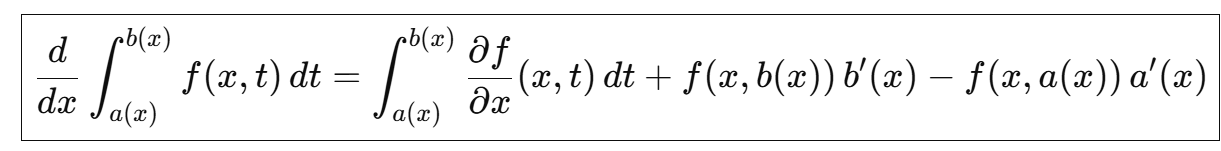

通过这个公式来进行。